In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import functools
import itertools

from pymicro.file import file_utils
import tensorflow as tf
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt, patches, cm
from sklearn import metrics as met

import tomo2seg.data as tomo2seg_data
from tomo2seg.data import ModelPaths, VolumePaths
from tomo2seg.volume_img_segm import VolumeImgSegmSequence
from tomo2seg import viz

In [3]:
dimensions = (500, 500, 500)
dtype = "uint8"  # todo remove the cast inside the generator?

# prefill the function `HST_read`
_hst_read = functools.partial(
    file_utils.HST_read,
    autoparse_filename=False,  # the file names are not properly formatted
    data_type=dtype,
    dims=dimensions,
    verbose=True,
)

hst_read = lambda x: _hst_read(str(x))

labels_list = [0, 1, 2]

class labels:
    matrix = 0
    fiber = 1
    hole = 2

In [4]:
# get a distribution strategy to use both gpus
# see https://www.tensorflow.org/guide/distributed_training
mirrored_strategy = tf.distribute.MirroredStrategy()  # todo add strategy to metadata

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [5]:
volume_paths = VolumePaths.with_check(tomo2seg_data.VOLUME_PRECIPITATES_DRYRUN)

[2020-10-26::16:32:44.578] tomo2seg :: WARNING :: {data.py:with_check:105}
Missing file: /home/users/jcasagrande/projects/tomo2seg/data/train.weights.PA66GF30_trans3_x__0_pag.raw
[2020-10-26::16:32:44.579] tomo2seg :: WARNING :: {data.py:with_check:105}
Missing file: /home/users/jcasagrande/projects/tomo2seg/data/val.weights.PA66GF30_trans3_x__0_pag.raw
[2020-10-26::16:32:44.580] tomo2seg :: WARNING :: {data.py:with_check:105}
Missing file: /home/users/jcasagrande/projects/tomo2seg/data/test.PA66GF30_trans3_x__0_pag.raw
[2020-10-26::16:32:44.581] tomo2seg :: WARNING :: {data.py:with_check:105}
Missing file: /home/users/jcasagrande/projects/tomo2seg/data/test.labels.PA66GF30_trans3_x__0_pag.raw
[2020-10-26::16:32:44.581] tomo2seg :: WARNING :: {data.py:with_check:105}
Missing file: /home/users/jcasagrande/projects/tomo2seg/data/test.PA66GF30_trans3_x__0_pag.raw.info
[2020-10-26::16:32:44.582] tomo2seg :: WARNING :: {data.py:with_check:105}
Missing file: /home/users/jcasagrande/projects/


## Validation volume

In [6]:
val_volume = hst_read(volume_paths.val_data_path)
val_volume.shape

data type is uint8
volume size is 500 x 500 x 500
reading volume... from byte 0


(500, 500, 500)

In [7]:
val_labels_volume = hst_read(volume_paths.val_labels_path)
val_labels_volume.shape

data type is uint8
volume size is 500 x 500 x 500
reading volume... from byte 0


(500, 500, 500)

# Model

In [8]:
model_name = "dryrun-03"
model_paths = ModelPaths(model_name)

In [9]:
with mirrored_strategy.scope():
    model = tf.keras.models.load_model(str(model_paths.autosaved_model_path) + ".hdf5")

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

# Processing

In [35]:
n_z_layers = 100
volume = val_volume[:, :, :n_z_layers]
crop_shape = (224, 224, 1)

volume.shape
# slice_indices = tuple((c0, c0 + d) for c0, d in zip(slice_coord, slice_dims))
# (sx0, sx1), (sy0, sy1), (sz0, sz1) = slice_indices

(500, 500, 100)

## Generate the crops

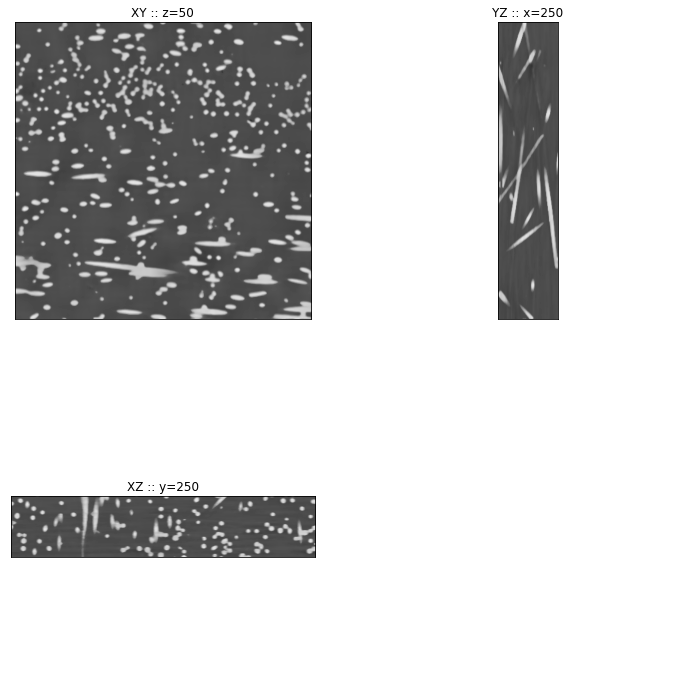

In [48]:
sz=12
fig, axs = plt.subplots(2, 2, figsize=(sz, sz))
viz.plot_orthogonal_slices(axs, volume)

In [49]:
n_steps = tuple(
    int(np.ceil(vol_dim / crop_dim))
    for vol_dim, crop_dim in zip(volume.shape, crop_shape)
)

n_steps

(3, 3, 100)

In [50]:
# coordinates (xs, ys, and zs) of the front upper left corners of the crops
x0s, y0s, z0s = tuple(
    tuple(map(
        int, 
        np.linspace(0, vol_dim - crop_dim, n)
    ))
    for vol_dim, crop_dim, n in zip(volume.shape, crop_shape, n_steps)
)
x0s, y0s, min(z0s), max(z0s), len(z0s)

((0, 138, 276), (0, 138, 276), 0, 99, 100)

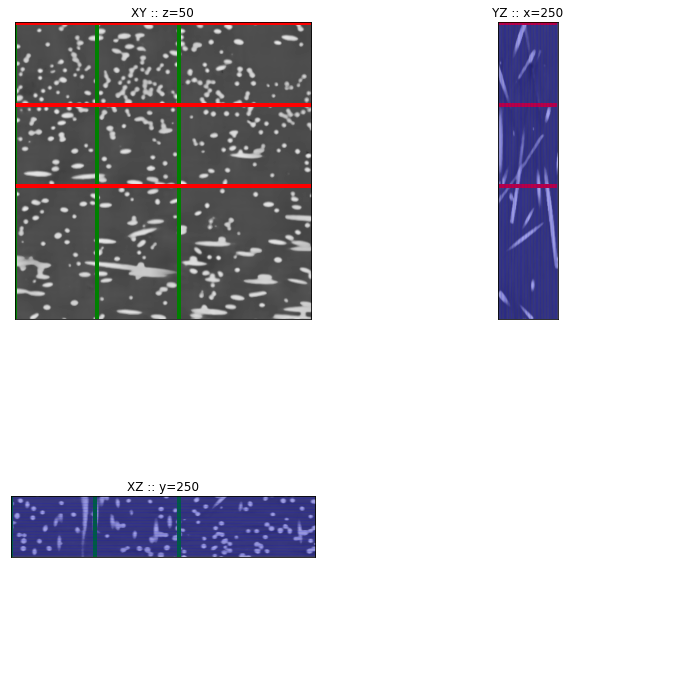

In [58]:
fig, axs = plt.subplots(2, 2, figsize=(sz, sz))
viz.plot_orthogonal_slices(axs, volume)

ax_xy = axs[0, 0]
ax_yz = axs[0, 1]
ax_xz = axs[1, 0]

for x_ in x0s:
    ax_xy.vlines(x_, 0, volume.shape[0] - 1, color='g', linewidth=4)
    ax_xz.vlines(x_, 0, volume.shape[2] - 1, color='g', linewidth=4)

for y_ in y0s:
    ax_xy.hlines(y_, 0, volume.shape[1] - 1, color='r', linewidth=4)
    ax_yz.hlines(y_, 0, volume.shape[2] - 1, color='r', linewidth=4)

for z_ in z0s:
    ax_yz.vlines(z_, 0, volume.shape[0] - 1, color='b', linewidth=0.2)    
    ax_xz.hlines(z_, 0, volume.shape[1] - 1, color='b', linewidth=0.2)

In [65]:
crops_coordinates = np.array([
    (
        (x0, x0 + crop_shape[0]), 
        (y0, y0 + crop_shape[1]),
        (z0, z0 + crop_shape[2]),
    )
    for x0, y0, z0 in itertools.product(x0s, y0s, z0s)
    
], dtype=tuple).reshape(len(x0s), len(y0s), len(z0s), 3, 2)

print(crops_coordinates.shape)
crops_coordinates

(3, 3, 100, 3, 2)


array([[[[[0, 224],
          [0, 224],
          [0, 1]],

         [[0, 224],
          [0, 224],
          [1, 2]],

         [[0, 224],
          [0, 224],
          [2, 3]],

         ...,

         [[0, 224],
          [0, 224],
          [97, 98]],

         [[0, 224],
          [0, 224],
          [98, 99]],

         [[0, 224],
          [0, 224],
          [99, 100]]],


        [[[0, 224],
          [138, 362],
          [0, 1]],

         [[0, 224],
          [138, 362],
          [1, 2]],

         [[0, 224],
          [138, 362],
          [2, 3]],

         ...,

         [[0, 224],
          [138, 362],
          [97, 98]],

         [[0, 224],
          [138, 362],
          [98, 99]],

         [[0, 224],
          [138, 362],
          [99, 100]]],


        [[[0, 224],
          [276, 500],
          [0, 1]],

         [[0, 224],
          [276, 500],
          [1, 2]],

         [[0, 224],
          [276, 500],
          [2, 3]],

         ...,

         [[0, 224],

# continue here!!!!!!!!!!!!!!

In [63]:
crops_coordinates = np.array([
    ((x0, x0 + crop_size), (y0 ,y0 + crop_size))
    for x0, y0 in itertools.product(x0s, y0s)
], dtype=tuple).reshape(len(x0s), len(y0s), 2, 2)
crops_coordinates

ValueError: cannot reshape array of size 5400 into shape (3,3,100,3,3)

In [26]:
crops_coordinates_sequential = crops_coordinates.reshape(-1, 2, 2)
crops_coordinates_sequential

array([[[0, 224],
        [0, 224]],

       [[0, 224],
        [138, 362]],

       [[0, 224],
        [276, 500]],

       [[138, 362],
        [0, 224]],

       [[138, 362],
        [138, 362]],

       [[138, 362],
        [276, 500]],

       [[276, 500],
        [0, 224]],

       [[276, 500],
        [138, 362]],

       [[276, 500],
        [276, 500]]], dtype=object)

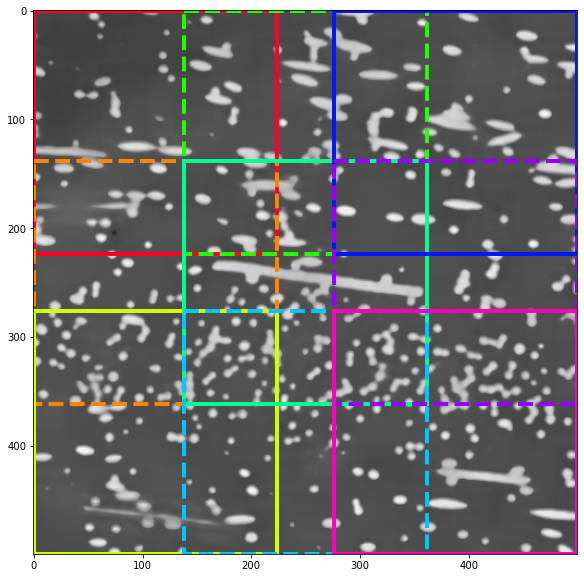

In [27]:
sz=10
fig, ax = plt.subplots(1, 1, figsize=(sz, sz))
ax.imshow(z_slice, cmap=cm.gray, vmin=0, vmax=255)

get_frame = functools.partial(
    patches.Rectangle,
    linewidth=4,
    facecolor='none',
)
linestyles = ['-', '--']

rainbow = plt.get_cmap('gist_rainbow')

# p is just a number beween 0 and 1 that represents
# the percentage of the linear path in the color space
for i, (((x0, x1), (y0, y1)), p) in enumerate(zip(crops_coordinates_sequential, np.linspace(0, 1, len(crops_coordinates_sequential)))):
    xy = (x0, y0) 
    width = x1 - x0
    height = y1 - y0
    frame = get_frame(xy, width, height, edgecolor=rainbow(p), ls=linestyles[i%len(linestyles)])
    ax.add_patch(frame)


In [28]:
(x0, x1), (y0, y1) = crops_coordinates[0, 0].tolist()

In [29]:
crops = np.array([
    [
        z_slice[x0:x1, y0:y1]
        for j in range(crops_coordinates.shape[1])
        for (x0, x1), (y0, y1) in [crops_coordinates[i, j].tolist()]
    ]
    for i in range(crops_coordinates.shape[0])
])
crops.shape, crops.dtype

((3, 3, 224, 224), dtype('uint8'))

In [30]:
sz=16
gridspace = .02
mysubplots = functools.partial(
    plt.subplots,
    figsize=(sz, sz), 
    sharey=True, 
    sharex=True, 
    gridspec_kw={"wspace": gridspace, "hspace": gridspace}
)

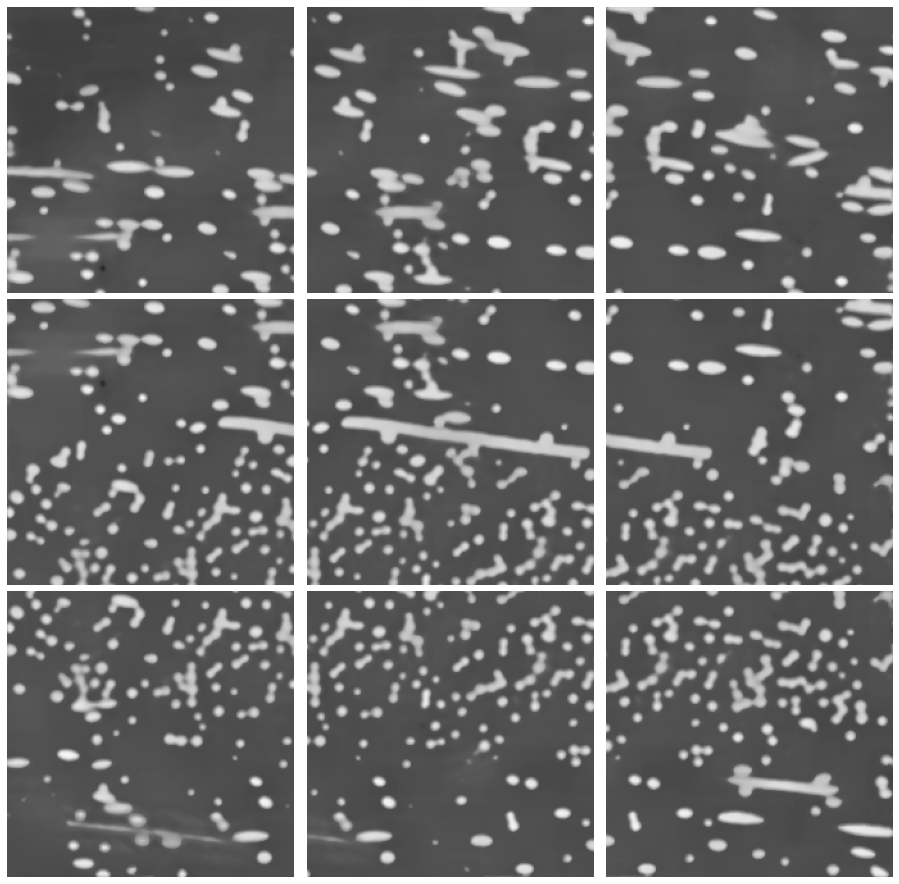

In [31]:
fig, axs = mysubplots(crops.shape[0], crops.shape[1])
for crop, ax in zip(crops.reshape(-1, crop_size, crop_size), axs.ravel()):
    ax.imshow(crop, cmap=cm.gray, vmin=0, vmax=255)
    ax.axis('off')

## Segment

(1, 224, 224, 1)
(1, 224, 224, 3)
(1, 224, 224)
(224, 224)


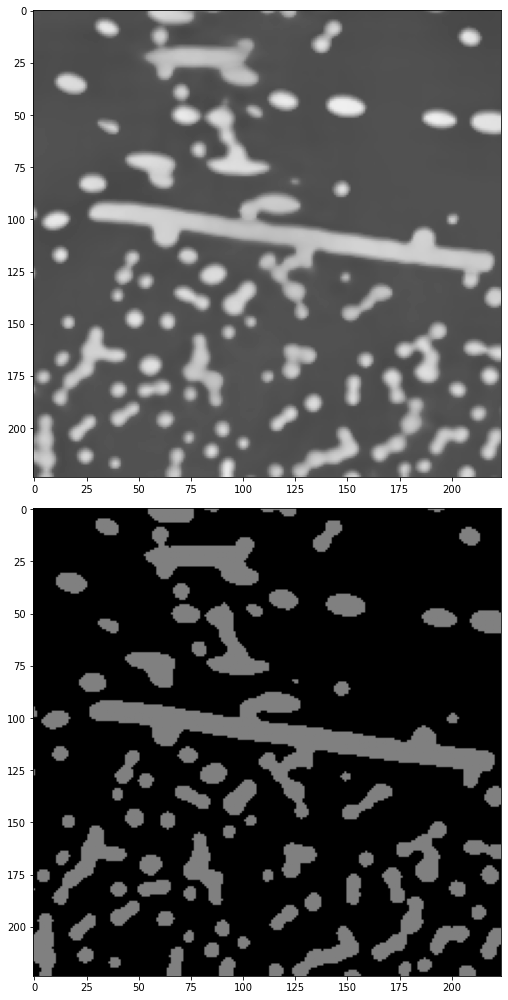

In [32]:
crop_ij = (1, 1)
crop_data = crops[crop_ij[0], crop_ij[1], :, :]

crop_data_modelin = crop_data.reshape(-1, crop_size, crop_size, 1) / 255  # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
print(crop_data_modelin.shape)

crop_probas = model.predict(crop_data_modelin, batch_size=1)
print(crop_probas.shape)

crop_preds = crop_probas.argmax(axis=-1)
print(crop_preds.shape)

crop_preds_im = crop_preds.reshape(224, 224) 
print(crop_preds_im.shape)

sz = 14
fig = plt.figure(figsize=(2 * sz, sz))
fig.set_tight_layout(True)

ax = plt.subplot(211)
ax.imshow(crop_data, vmin=0, vmax=255, cmap=cm.gray)

ax = plt.subplot(212)
plt.imshow(crop_preds_im, vmin=0, vmax=2, cmap=cm.gray)

In [33]:
proba_crops = np.empty(list(crops.shape) + [3], dtype=np.float)
proba_crops.shape, proba_crops.dtype

((3, 3, 224, 224, 3), dtype('float64'))

In [34]:
pred_crops = np.empty_like(crops)
pred_crops.shape, pred_crops.dtype

((3, 3, 224, 224), dtype('uint8'))

In [35]:
ij_iterator = itertools.product(range(pred_crops.shape[0]), range(pred_crops.shape[1]))

for i, j in ij_iterator:
    proba_crops[i, j, :, :, :] = model.predict(crops[i, j, :, :].reshape(-1, crop_size, crop_size, 1) / 255)  # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    pred_crops[i, j, :, :] = proba_crops[i, j, :, :].argmax(axis=-1)

(224, 224, 3)


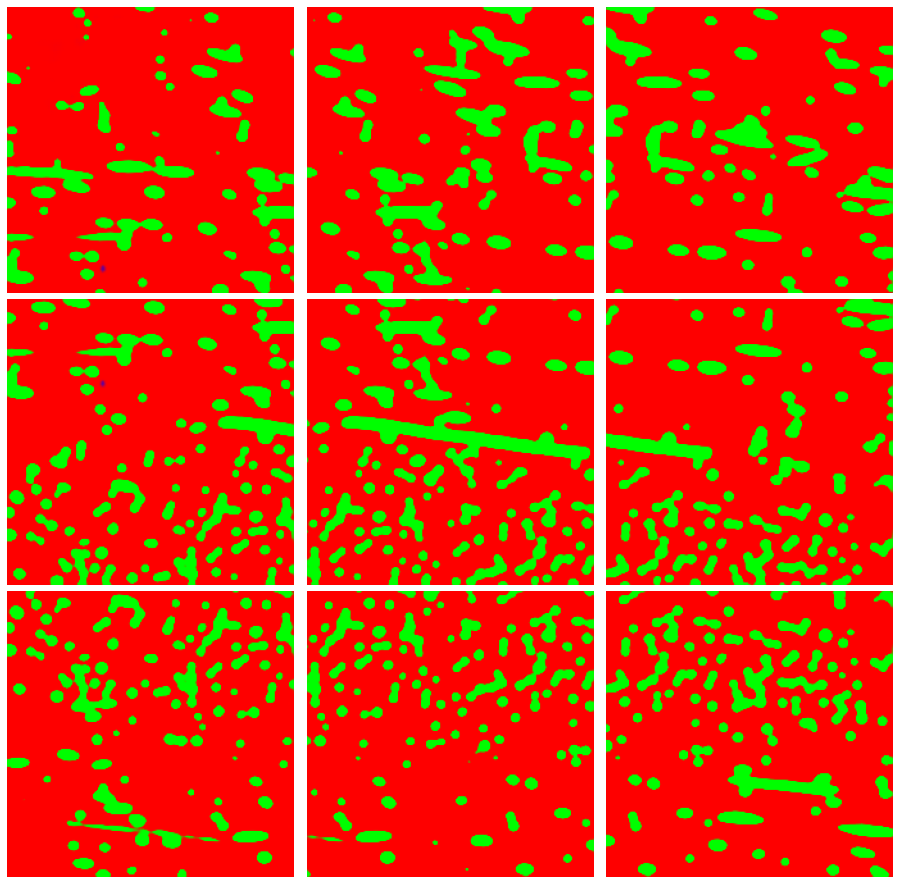

In [36]:
fig, axs = mysubplots(crops.shape[0], crops.shape[1])
for proba_crop, ax in zip(proba_crops.reshape(-1, crop_size, crop_size, proba_crops.shape[-1]), axs.ravel()):
    ax.imshow(proba_crop)  # interpreted as rgb if there are 3 classes
    ax.axis('off')
print(proba_crop.shape)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


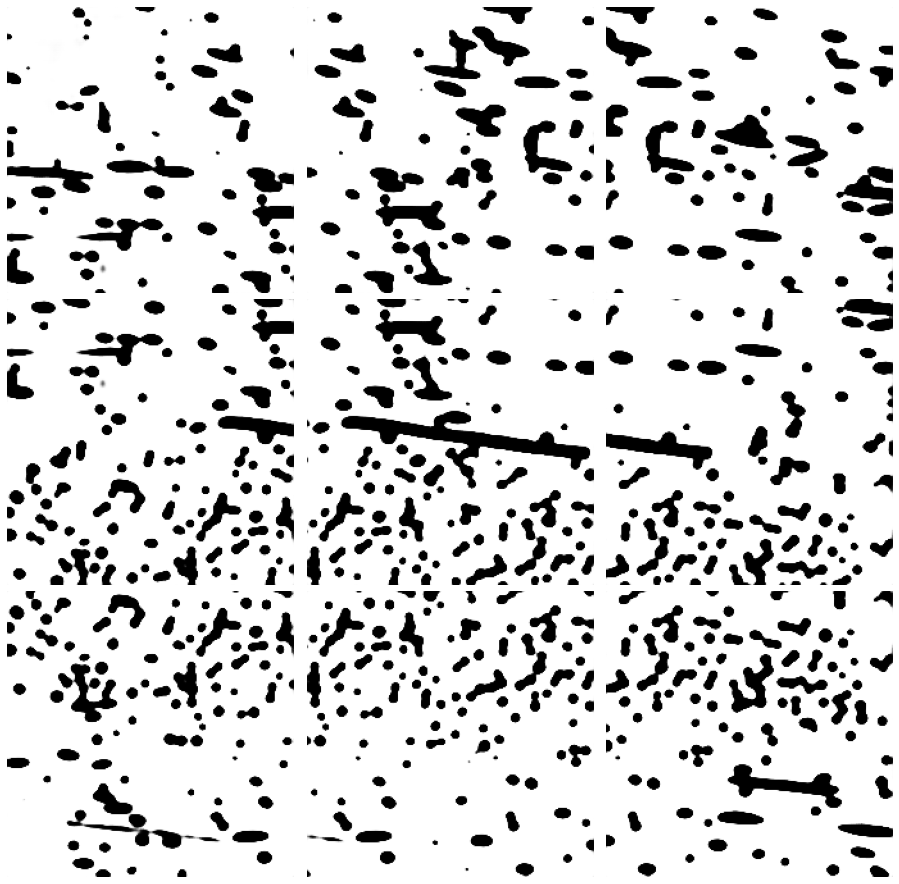

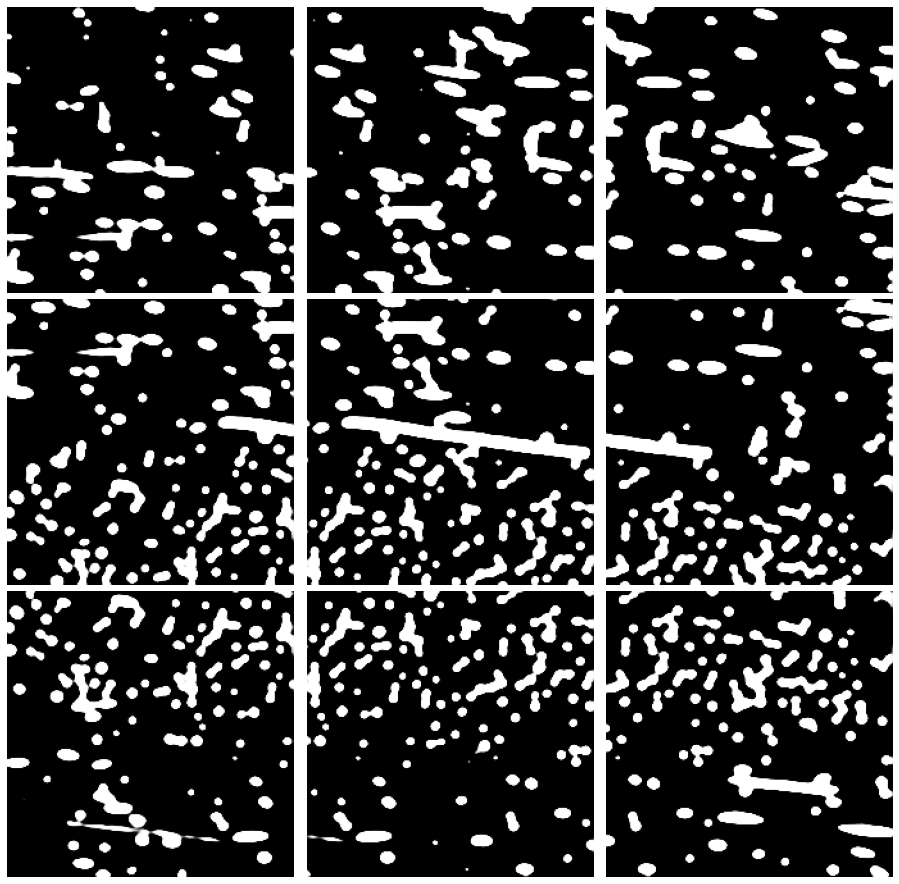

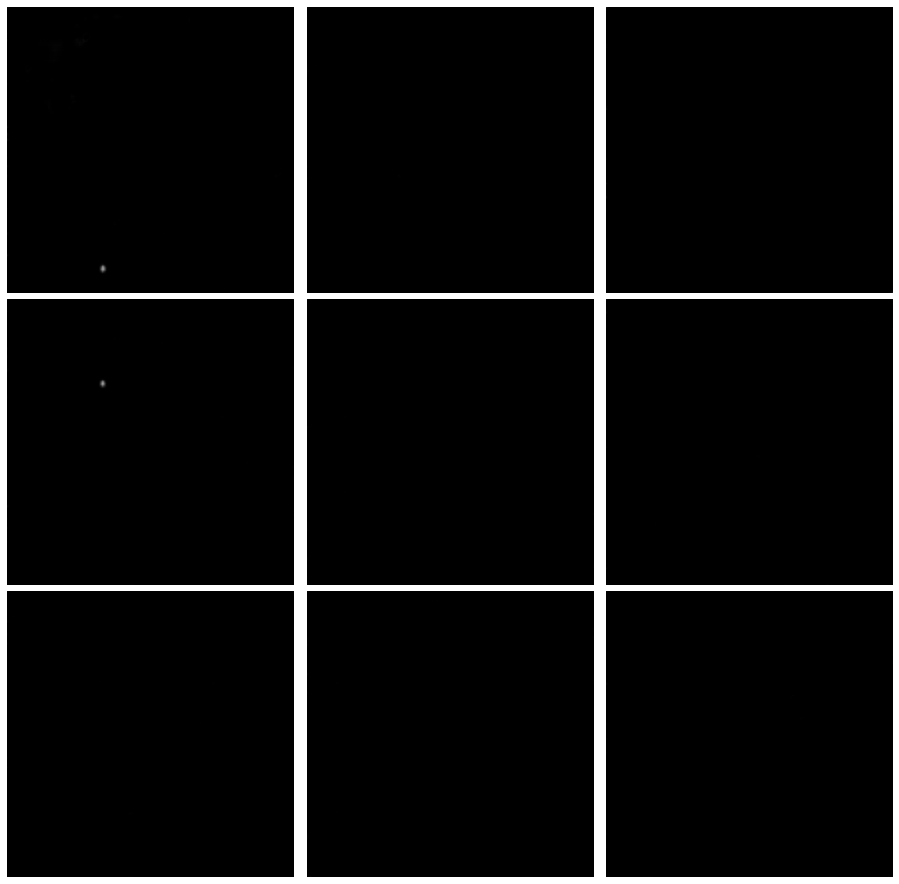

In [37]:
for class_ in [0, 1, 2]:
    fig, axs = mysubplots(crops.shape[0], crops.shape[1])
    for proba_crop, ax in zip(proba_crops.reshape(-1, crop_size, crop_size, proba_crops.shape[-1]), axs.ravel()):
        ax.imshow(proba_crop[:, :, class_], vmin=0, vmax=1, cmap=cm.gray)  # interpreted as rgb if there are 3 classes
        ax.axis('off')
    print(proba_crop.shape)

(224, 224)


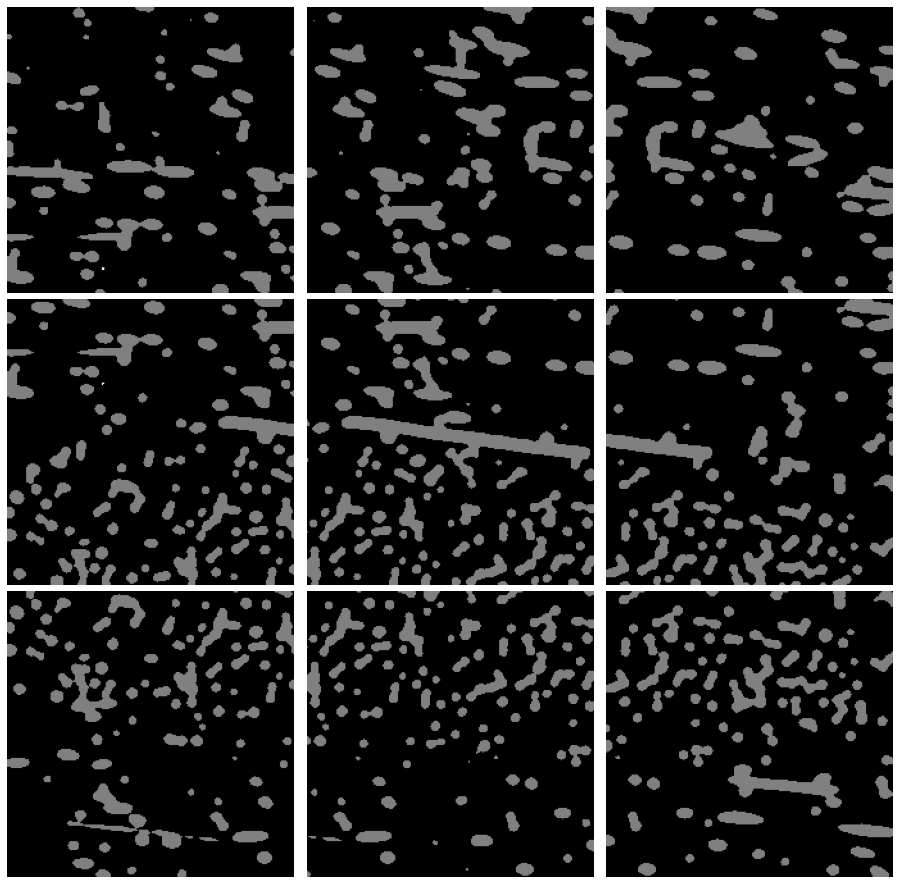

In [38]:
fig, axs = mysubplots(crops.shape[0], crops.shape[1])

for pred_crop, ax in zip(pred_crops.reshape(-1, crop_size, crop_size), axs.ravel()):
    ax.imshow(pred_crop, vmin=0, vmax=2, cmap='gray')
    ax.axis('off')
print(pred_crop.shape)

# Rebuild the slice

In [46]:
crop_size

224

In [40]:
slice_dims

(500, 500)

In [45]:
crops.shape

(3, 3, 224, 224)

In [42]:
crops_coordinates.shape

(3, 3, 2, 2)

In [43]:
crops_coordinates[0, 0]

array([[0, 224],
       [0, 224]], dtype=object)

In [75]:
for coord, crop, _ in zip(
    crops_coordinates.reshape(-1, 2, 2), 
    crops.reshape(-1, crop_size, crop_size), 
    range(4)
):
    (x0, x1), (y0, y1) = coord

In [76]:
coord

array([[138, 362],
       [0, 224]], dtype=object)

In [77]:
coord.shape

(2, 2)

In [78]:
x0, x1, y0, y1

(138, 362, 0, 224)

In [79]:
crop.shape 

(224, 224)

In [82]:
rebuilt_slice = np.empty(slice_dims)
rebuilt_slice.shape

redundancies_count = np.zeros(slice_dims)

In [84]:
for coord, crop in zip(
    crops_coordinates.reshape(-1, 2, 2), 
    crops.reshape(-1, crop_size, crop_size) 
):
    (x0, x1), (y0, y1) = coord
    rebuilt_slice[x0:x1, y0:y1] = crop.copy()
    redundancies_count[x0:x1, y0:y1] += np.ones_like(crop)

True

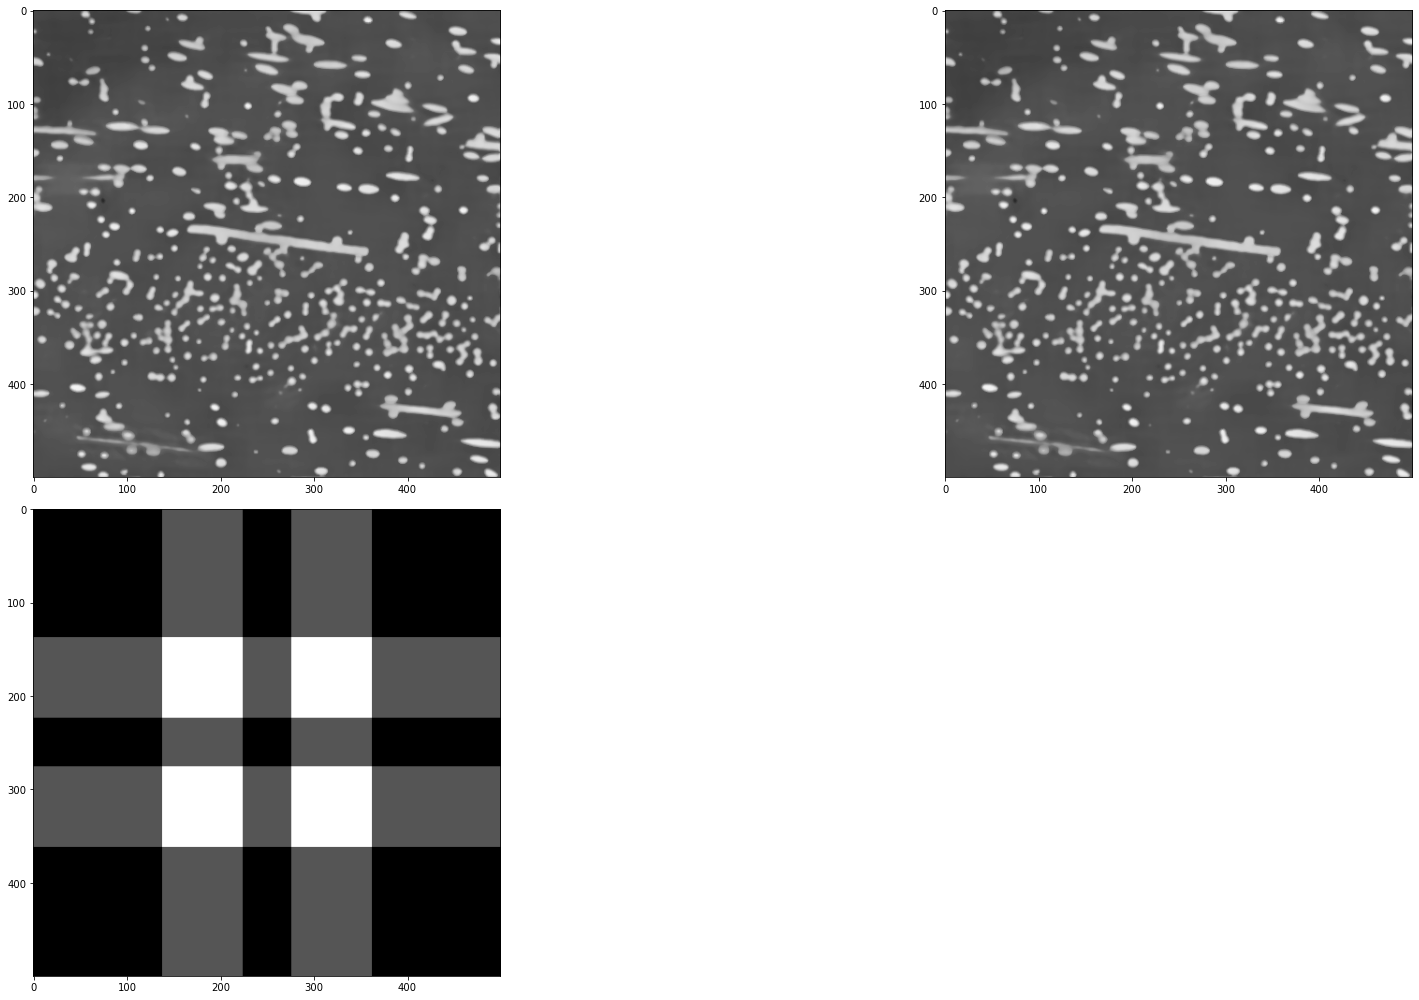

In [88]:
sz = 14
fig = plt.figure(figsize=(2 * sz, sz))
fig.set_tight_layout(True)

ax = plt.subplot(221)
ax.imshow(z_slice, vmin=0, vmax=255, cmap=cm.gray)

ax = plt.subplot(222)
plt.imshow(rebuilt_slice, vmin=0, vmax=255, cmap=cm.gray)


ax = plt.subplot(223)
plt.imshow(redundancies_count, cmap=cm.gray)

np.all(rebuilt_slice == z_slice)

In [146]:
proba_sum_slice = np.zeros(tuple(list(slice_dims) + [proba_crops.shape[-1]]))
proba_slice = np.empty_like(proba_sum_slice)
redundancies_count = np.zeros(slice_dims)

proba_sum_slice.shape, pred_slice.shape

((500, 500, 3), (500, 500))

In [147]:
for coord, proba_crop in zip(
    crops_coordinates.reshape(-1, 2, 2), 
    proba_crops.reshape(-1, crop_size, crop_size, proba_crops.shape[-1])
):
    (x0, x1), (y0, y1) = coord
    proba_sum_slice[x0:x1, y0:y1] += proba_crop
    redundancies_count[x0:x1, y0:y1] += np.ones((crop_size, crop_size))

In [148]:
# check that the min and max probas are coherent with the min/max redundancy
proba_sum_slice.min(axis=0).min(axis=0), proba_sum_slice.max(axis=0).max(axis=0), np.min(redundancies_count), np.max(redundancies_count)

(array([1.19640244e-08, 2.68363021e-09, 3.18484475e-11]),
 array([4.        , 4.        , 1.19392723]),
 1.0,
 4.0)

In [149]:
# divide each probability channel by the number of times it was summed (avg proba)
for klass_idx in range(proba_sum_slice.shape[-1]):
    proba_slice[:, :, klass_idx] =  proba_sum_slice[:, :, klass_idx] / redundancies_count    
    
proba_slice.shape

(500, 500, 3)

In [154]:
# check that proba distribs sum to 1
proba_slice.sum(axis=-1).min(), proba_slice.sum(axis=-1).max()

(0.9999998560226686, 1.000000142666977)

In [153]:
pred_slice = proba_slice.argmax(axis=-1)

In [156]:
pred_slice.shape, pred_slice.min(), pred_slice.max()

((500, 500), 0, 2)

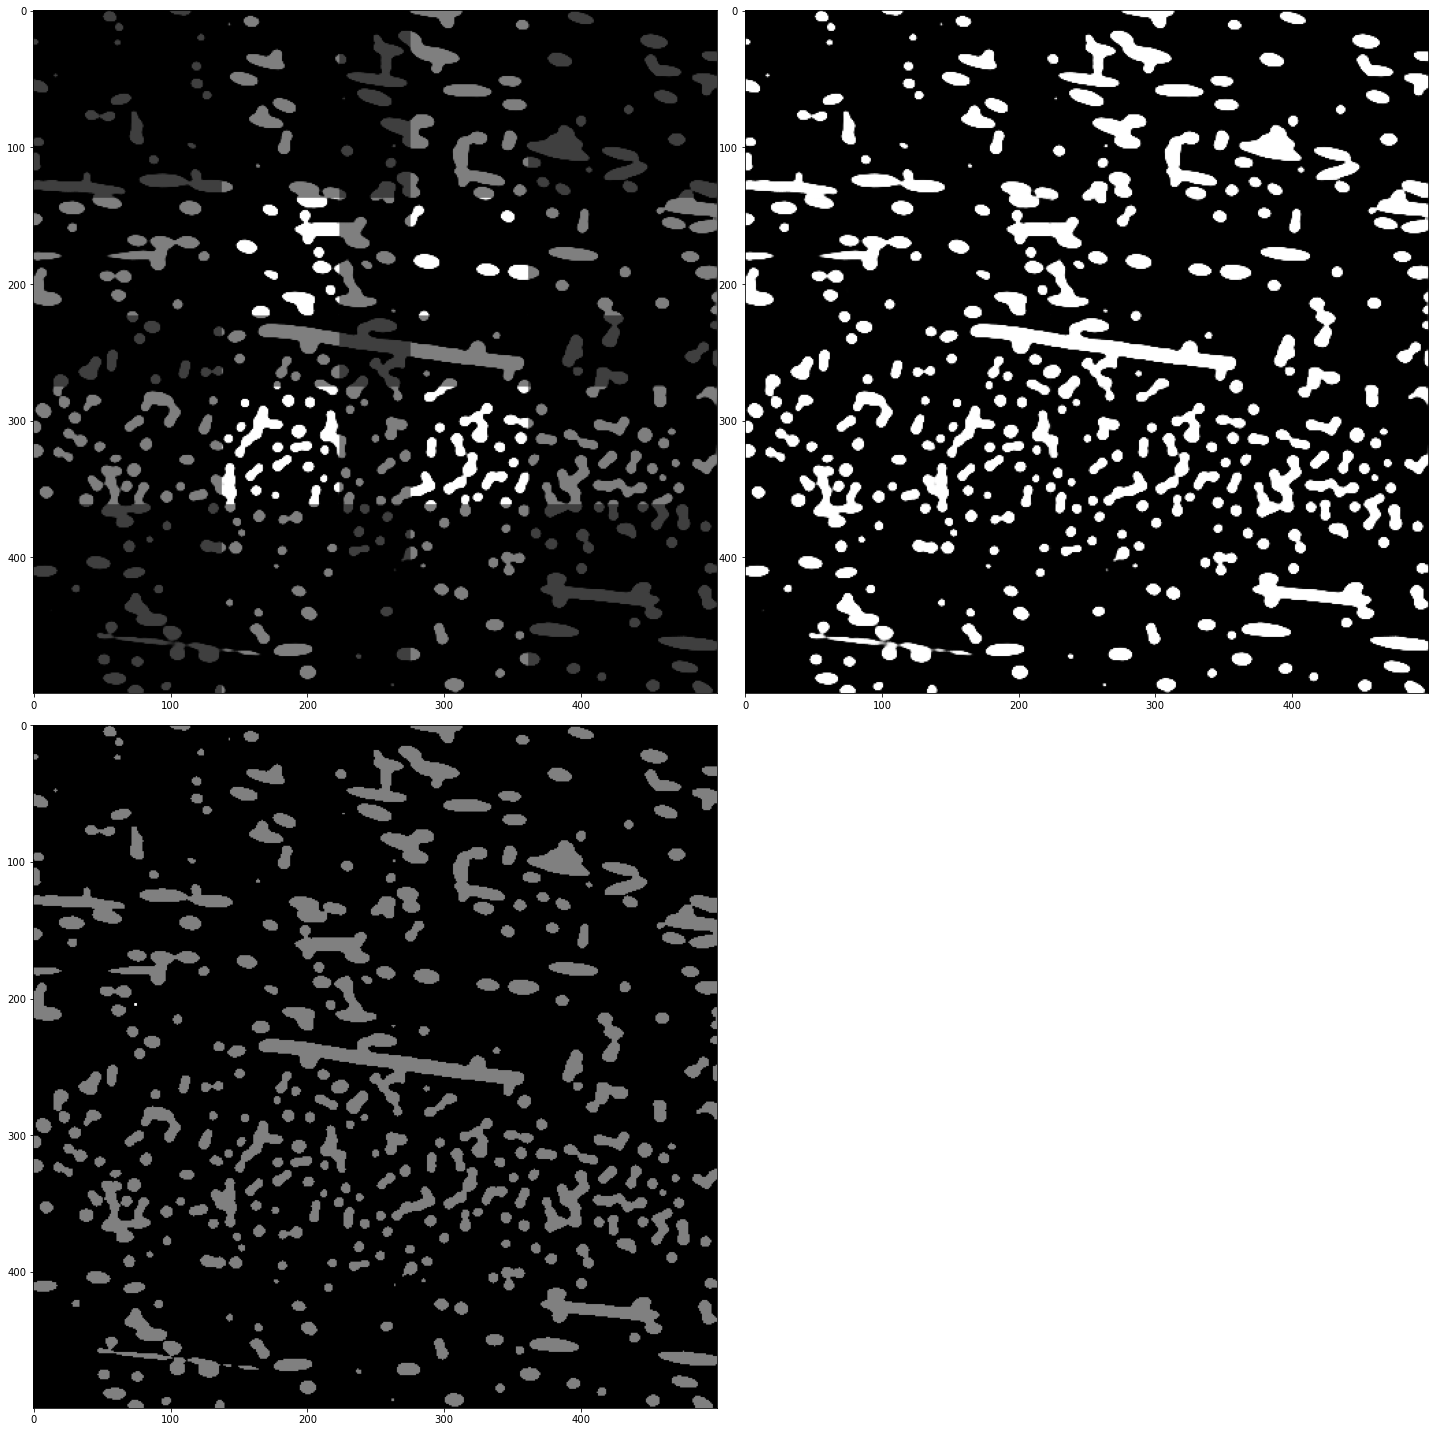

In [160]:
klass_idx = 1

sz = 20
fig = plt.figure(figsize=(sz, sz))
fig.set_tight_layout(True)

ax = plt.subplot(221)
ax.imshow(proba_sum_slice[:, :, klass_idx], vmin=0, vmax=np.max(redundancies_count), cmap=cm.gray)

ax = plt.subplot(222)
plt.imshow(proba_slice[:, :, klass_idx], vmin=0, vmax=1, cmap=cm.gray)

ax = plt.subplot(223)
ax.imshow(pred_slice, vmin=0, vmax=2, cmap=cm.gray)